In [ ]:
from Tissue_Objects import *
from CommonOperations import *

def write_cell_edges(T):
    for c in T.ListCell:
        print(c.area)
        if c.crossBdry:
            continue
        tail_edges = []
        dl_edges = []
        for E in c.ListEdges:
            e = E[0]
            tail_edges.append([e.tailVertex.coord.x, e.tailVertex.coord.y])
            dl_edges.append([e.dl.x, e.dl.y])
            image_name = 'cells/'+str(c.Number)+'.png'
            plot_cell_edges(tail_edges, dl_edges, image_name)
            
def visulaise_frames(n_steps, skip, color_type):
    for i in np.arange(0,int(n_steps-1), skip):
        data_name = "data/T"+str(i)+".json"
        image_name = "images/t"+str(i).zfill(5)+".png"
        visualize_frame_jsonfile(data_name, image_name, color_type)

def run_simulation(Nx, Ny, Ta, Kc, A0c, Gc, sim_type):
    T = Tissue(Ta, Kc, A0c, Gc)
    T.create_hexagonal_tissue(Nx, Ny, Kc, A0c, Ta, Gc)
    T.update_derivatives_analytically()
    
    n_steps, dt, write_freq = 2000, 0.1, 500
    
    T.minimize_dynamically(n_steps, dt, write_freq, False, False)
    
    delta = 0.06*np.sqrt(T.A0c) # opening length of edge
    
    v_cent = T.find_vertex_at_center()
    if sim_type=='4fold':
        shrinking_edge = v_cent.connectedEdges[0]
        T.shrink_edge_to_vertex(shrinking_edge)
        T.minimize_dynamically(2*n_steps, dt, write_freq, False, False)
        for v in T.ListVertex:
            if len(v.connectedEdges)==4:
                T.open_vertex_to_cell(v,delta)
    elif sim_type=='3fold':
        T.open_vertex_to_cell(v_cent,delta)
    elif sim_type=='both_sides':
        e = v_cent.connectedEdges[0]
        T.open_vertex_to_cell(e.tailVertex,delta)
        T.open_vertex_to_cell(e.headVertex,delta)
    elif sim_type=='randomized_packing':
        for i in range(10):
            n_e = len(T.ListEdge)
            eid = random.randrange(n_e)
            e = T.ListEdge[eid]
            if e.crossBdry or e.c1.crossBdry or e.c2.crossBdry:
                continue
            if len(e.c1.ListEdges)>5 and len(e.c2.ListEdges)>5:
                T.shrink_edge_to_vertex(e)
            #T.shrink_random_edge()
        T.minimize_dynamically(n_steps, dt/2.0, write_freq, False, False)
        for v in T.ListVertex:
            dr = Point(random.uniform(-1.0,1.0), random.uniform(-1.0,1.0), 0)
            v.coord = v.coord +dr.X(0.1)
    elif sim_type=='quadruple':
        shrinking_edge = v_cent.connectedEdges[0]
        T.flip_edge(shrinking_edge)
    elif sim_type=='randomized_tension':
        gamma_mean = T.Ta
        gamma_std = T.Ta/5.0
        Tvalues = np.random.normal(gamma_mean, gamma_std, len(T.ListEdge))
        for i in range(len(Tvalues)):
            if T.ListEdge[i].c1.crossBdry or T.ListEdge[i].c2.crossBdry:
                continue
            T.ListEdge[i].lineTension = Tvalues[i]

    n_steps, dt, write_freq = 100000, 0.1, 500
    W_steps = T.minimize_dynamically(n_steps, dt, write_freq, True, True)
    datafile = '/Users/aamiri/Documents/research/projects/vertexModeling/python_VModel_v2/data/T'+str(n_steps)+'.json'
    color_type = 'dW_dh'
    image_name = 'gamma'+str(Ta)+color_type+'.pdf'
    visualize_frame_jsonfile(datafile, image_name, color_type)
    color_type = 'd2W_dv2'
    image_name = 'gamma'+str(Ta)+color_type+'.pdf'
    visualize_frame_jsonfile(datafile, image_name, color_type)
    visulaise_frames(n_steps, write_freq, color_type)
    return T, W_steps
#===========================================================
Nx, Ny = 18, 18
#Ta (or \gamma): line tension
Ta, Kc, A0c, Gc = 0.01, 1.0, 1.0, 0
#sim_type = 'randomized_packing'
sim_type = 'randomized_tension'

T, W_steps = run_simulation(Nx, Ny, Ta, Kc, A0c, Gc, sim_type)

In [10]:
from Tissue_Objects import *
from CommonOperations import *
Ta = 0.01
datafile = '/Users/aamiri/Documents/research/projects/vertexModeling/python_VModel_v2/data/T2000.json'
image_name = 'nematics_gamma'+str(Ta)+'d2w_dv2.pdf'
color_type = 'd2W_dv2'
visualize_frame_jsonfile(datafile, image_name, color_type)

In [8]:
for v in T.ListVertex:
    print(v.dW_dv)

(7.263244754909511e-06,-4.108338465600309e-06,0.0)
(8.79602749625125e-06,-4.7870331818745455e-06,0.0)
(1.1406624873877879e-05,-3.1331523384823493e-06,0.0)
(1.0886019752744781e-05,-2.9326348229703736e-06,0.0)
(9.187002126805126e-06,-3.0344963238416295e-06,0.0)
(7.2565281264286025e-06,-5.29283358540543e-06,0.0)
(-5.8651012484960905e-06,-3.3258549689208416e-06,0.0)
(1.4161994863493834e-06,-6.7594065962667e-06,0.0)
(8.654174249833098e-06,-3.667035984025686e-06,0.0)
(-2.3987858404794673e-06,-1.3067418642486524e-05,0.0)
(1.8483012559698635e-06,4.5310494696580803e-07,0.0)
(6.532620266713328e-06,-4.716855431423925e-06,0.0)
(9.114429975535768e-06,-5.048717126465859e-06,0.0)
(9.805394694455388e-06,-4.718524680546749e-06,0.0)
(5.60603892292358e-07,3.4874840561757194e-06,0.0)
(7.780373572782826e-06,-1.4067352377260278e-06,0.0)
(5.081129658823325e-06,-4.529233196200655e-06,0.0)
(2.297209948413799e-06,1.4568935071037588e-06,0.0)
(6.6980189758036445e-06,-1.240160895423436e-05,0.0)
(8.23148534694583e-

In [10]:
print(T.SystemSize)
for v in T.ListVertex:
    if len(v.connectedEdges)==4:
        print(v.Number)
for c in T.ListCell:
    if len(c.ListEdges)!=6:
        print(c.center)

(12.894839181882501,11.167258309225197)
286
(1.5702415571720207,6.241363206322272,0.0)
(2.158814085927995,7.56684003541753,0.0)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


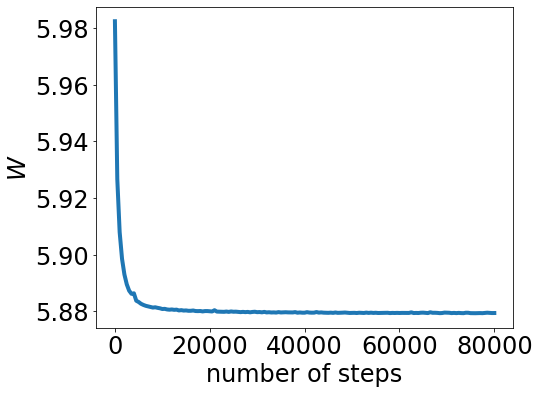

In [4]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 24
       }

fig, ax = plt.subplots(1,1,figsize=(8,6))

plt.rc('font', **font)
steps = np.arange(0,80001,500)
ax.plot(steps, W_steps, linewidth=4)
ax.set_xlabel('number of steps')
ax.set_ylabel('$W$')
plt.tight_layout()
plt.savefig('minimization_steps_gamma'+str(Ta)+'.pdf')
plt.show()

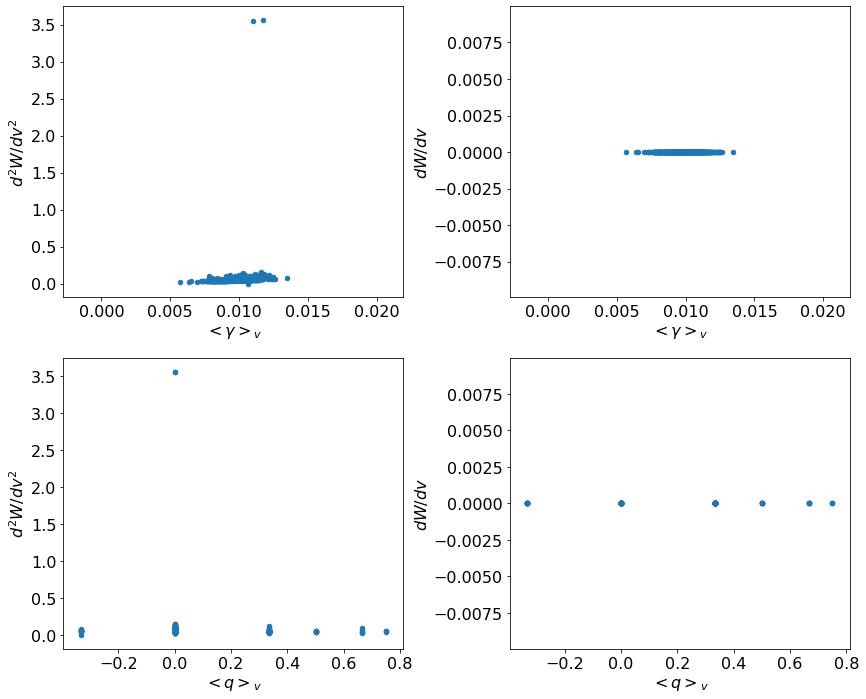

In [7]:
d2w_dh2 = [v.d2W_dh2 for v in T.ListVertex]
dw_dh = [v.Norm_dW_dh for v in T.ListVertex]
gamma_avg = []
q_avg = []
for v in T.ListVertex:
    gammas = [e.lineTension for e in v.connectedEdges]
    gamma_avg.append(np.mean(gammas))
    polycharges = [6-len(cor.c.ListEdges) for cor in v.ListCorners]
    q_avg.append(np.mean(polycharges))
    
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16
       }

fig, axes = plt.subplots(2,2,figsize=(12,10))

plt.rc('font', **font)

v_area = 20
ax = axes.flat[0]
ax.scatter(gamma_avg, d2w_dh2, s=v_area)#, c=colors)#, alpha=0.0)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('$<{\gamma}>_v$')
ax.set_ylabel('$d^2W/dv^2$')

ax = axes.flat[1]
ax.scatter(gamma_avg, dw_dh, s=v_area)#, c=colors)#, alpha=0.0)
ax.set_xlabel('$<\gamma>_v$')
ax.set_ylabel('$dW/dv$')

ax = axes.flat[2]
ax.scatter(q_avg, d2w_dh2, s=v_area)#, c=colors)#, alpha=0.0)
ax.set_xlabel('$<q>_v$')
ax.set_ylabel('$d^2W/dv^2$')

ax = axes.flat[3]
ax.scatter(q_avg, dw_dh, s=v_area)#, c=colors)#, alpha=0.0)
ax.set_xlabel('$<q>_v$')
ax.set_ylabel('$dW/dv$')

plt.tight_layout()
plt.savefig('probing_vertex_'+str(Ta)+'.pdf')
plt.show()

In [1]:
Ta=0.002
from CommonOperations import *
from matplotlib import colors as mcolors
datafile = '/Users/aamiri/Documents/research/projects/vertexModeling/python_VModel_v2/data/T10000.json'
image_name = 'gamma'+str(Ta)+'d2w_dv2.pdf'
color_type = 'd2W_dv2'
visualize_frame_jsonfile(datafile, image_name, color_type)

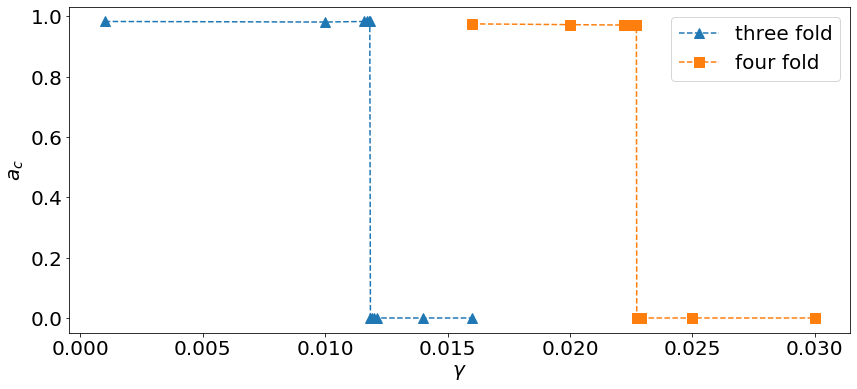

In [10]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
#matplotlib.rc('text', usetex=True)


threefold = ['0.0100', '0.0116', '0.0117', '0.0118', '0.011825', '0.01185', '0.0119', '0.0120', '0.0121']
fourfold = ['0.020', '0.0222', '0.0223', '0.0224', '0.0225', '0.0226', '0.0227', 
            '0.0227125', '0.022725', '0.02275', '0.0228', '0.0229' ]
base_folder = '/Users/aamiri/Desktop/Amin/vertexModel/'
# for three fold
Ac_three = [0.983]
Ta_three = [0.001]
for threefolder in threefold:
    datafile = base_folder + 'threefold/' + threefolder + '/data/T49950.json'
    Ta_three.append(float(threefolder))
    with open(datafile, 'r') as fp:
        data = json.load(fp)
        area_cells = data["cell_area"]
        Ac_three.append(area_cells[-1])
        
Ac_three.append(0.0)
Ta_three.append(0.014)
Ac_three.append(0.0)
Ta_three.append(0.016)

Ac_four = [0.975]
Ta_four = [0.016]
for fourfolder in fourfold:
    datafile = base_folder + 'fourfold/' + fourfolder + '/data/T49950.json'
    Ta_four.append(float(fourfolder))
    with open(datafile, 'r') as fp:
        data = json.load(fp)
        area_cells = data["cell_area"]
        Ac_four.append(area_cells[-1])
        
Ac_four.append(0)
Ta_four.append(0.025)
Ac_four.append(0)
Ta_four.append(0.03)
        
# plot the data
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(Ta_three, Ac_three, '^--', markersize=10, label='three fold')
ax.plot(Ta_four, Ac_four, 's--', markersize=10, label='four fold')
plt.ylabel('$a_c$')
plt.xlabel('$\gamma$')
plt.legend()
plt.savefig('together.pdf')
plt.show()
#plt.plot(Ta_three, Ac_three, '.')
#plt.show()

In [3]:
A = [c.area for c in T.ListCell]
T.ListCell[-1].area

NameError: name 'T' is not defined

In [5]:
str(49500).zfill(5)

'49500'

In [5]:
A = np.random.normal(0.002, 0.001, 100)
min(A)

-0.00028556516940576827